# University of Aberdeen

## Applied AI (CS5079)

### Resit CA1 - Reinforcement Learning with OpenAI Gym

In [1]:
#Library for environments
import gym
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map

#Librairies to represent the output
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

#Essential libraries for computation
import numpy as np
import random
from setuptools import dist
import tensorflow.compat.v1 as tf
from collections import deque

We will use the following environment.

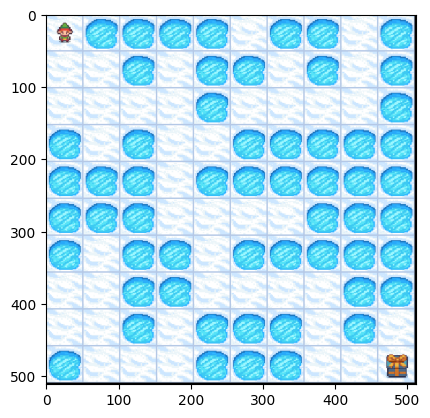

In [82]:
from IPython.display import display
random_map = generate_random_map(size=10, p=0.3)    
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
display(plt.gcf())
clear_output(wait=True)

In [3]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber

In [83]:
%matplotlib inline
class QLearningAgent:
    def __init__(self, env, exploration_probability=1, learning_rate=0.1, discount_factor=0.95,\
                  max_epsilon=1.0, min_epsilon=0.005, decay_rate=0.005, \
                    max_learning_rate=0.9, min_learning_rate=0.3, decay_learning_rate=0.0001):
        self.env = env
        self.exploration_probability = exploration_probability
        self.learning_rate = learning_rate
        self.max_learning_rate = max_learning_rate
        self.min_learning_rate = min_learning_rate
        self.decay_learning_rate = decay_learning_rate
        self.discount_factor = discount_factor
        self.space_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.max_epsilon = max_epsilon            # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.decay_rate = decay_rate      # Exponential decay rate for exploration prob
        self.Q_table = np.zeros((self.space_size, self.action_size))
        self.rewards = []
        # ------------------------------------------------------------------------------------------------------
        # Open for interpretation
        self.model = Sequential([
            Dense(64, activation='relu', input_dim=self.space_size),
            Dense(64, activation='relu'),
            Dense(self.action_size, activation='linear')])
        self.model.compile(optimizer='Adam', loss=Huber())
        # ------------------------------------------------------------------------------------------------------

    def train(self, episodes=100):
        for i, episode in enumerate(range(episodes)):
            state = self.env.reset()[0]
            done = False
            truncated = False
            score = 0
            while not done and not truncated:
                # Take a random value between the range of 0-1, if it is less than our exploration rate probability then we take a random action
                trade_off = random.uniform(0, 1)
                if trade_off < self.exploration_probability or np.sum(self.Q_table[state, :]) == 0:
                    action = self.env.action_space.sample()
                else:
                    # Selects action with the highest Q-value for the current state
                    action = np.argmax(self.Q_table[state, :])

                next_state, reward, done, truncated, info = self.env.step(action)
                # print(next_state, reward, done)
                # Q(s,a)=(1−α)⋅Q(s,a)+α⋅(R+γ⋅maxa'Q(s',a'))
                self.Q_table[state, action] = self.Q_table[state, action] + self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state, :]) - self.Q_table[state, action])

                score += reward
                state = next_state

                # if done:
            plt.imshow(self.env.render())
            display(plt.gcf())
            clear_output(wait=True)
                    # complete = True
                    # print(f"Episode {episode + 1} Score {score}")
            self.learning_rate = self.min_learning_rate + (self.max_learning_rate - self.min_learning_rate)*np.exp(-self.decay_learning_rate*episode)
            self.exploration_probability = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay_rate*episode)
            self.rewards.append(score)
            if i % 10000 == 0:
                print(f"Episode {episode + 1} Score {score} Learning Rate {self.learning_rate} Exploration Probability {self.exploration_probability}")
            # print(self.learning_rate, self.exploration_probability)


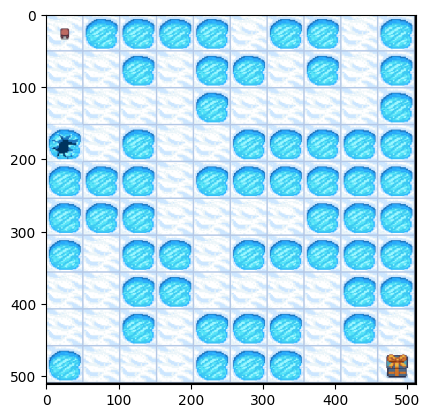

In [ ]:
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", )
env.reset()
agent = QLearningAgent(env)

# Train the agent
agent.train(episodes=1000000)
print(agent.Q_table)


# Close the environment
env.close()


In [78]:
max(agent.rewards)

0.0